In [1]:
import hmclab
import matplotlib.pyplot as plt
import numpy
from mpl_toolkits.axes_grid1 import AxesGrid

/Users/larsgebraad/.conda/envs/hmclab-dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Tutorial 4 - Running parallel Markov chains

Sometimes one wants to run multiple Markov chains in various scenarios. This can be to e.g.:

- speed up convergence, by combining the results of multiple Markov chains;
- explore local minima fast, by parallel tempering;
- couple different inverse problems and let them exchange inforamtion, by replica exchange.

In this notebook, we will go through all these cases, and explain how our samplers can helps you with this.

Note that all these examples are based on single-machine parallelism, i.e. a single node with multiple cores and unified memory. This is not intended to be run on HPC clusters.

## Our target: multi-modal distributions

One of the more challenging settings for MCMC appraisal of Bayesian posteriors is when a distribution has multiple local minima of interest.

In [2]:
class StyblinskiTang(hmclab.Distributions._AbstractDistribution):
    def __init__(self, dimensions=None, temperature=6.5):
        if dimensions is None:
            self.dimensions = 2
        else:
            self.dimensions = dimensions
        self.temperature = temperature

    def misfit(self, m):
        assert m.shape == (self.dimensions, 1)
        return 0.5 * numpy.sum(m**4 - 16 * (m**2) + 5 * m) / self.temperature

    def gradient(self, m):
        assert m.shape == (self.dimensions, 1)
        return 0.5 * (4 * (m**3) - 32 * m + 5) / self.temperature

    def generate(self, m):
        raise NotImplementedError()

In [3]:
n_samples = 10000
base_temperature = 3
base_target = StyblinskiTang(temperature=base_temperature)

In [4]:
n1 = 100
n2 = 100
m1 = numpy.linspace(-5, 5, n1)
m2 = numpy.linspace(-5, 5, n1)

d1 = m1[1] - m1[0]
d2 = m2[1] - m2[0]

misfit = numpy.empty((n1, n1))

for i1, m1i1 in enumerate(m1):
    for i2, m2i2 in enumerate(m2):

        m = numpy.vstack([m1i1, m2i2])

        misfit[i1, i2] = base_target.misfit(m)

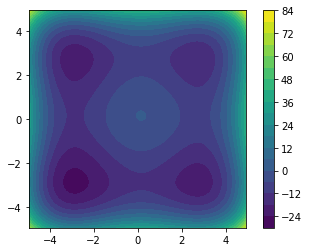

In [5]:
plt.subplot(1, 1, 1, aspect="equal")
plt.contourf(
    misfit,
    20,
    extent=[numpy.min(m1), numpy.max(m1), numpy.min(m2), numpy.max(m2)],
    origin="lower",
)
_ = plt.colorbar()

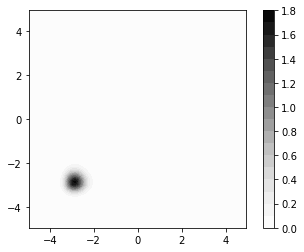

In [6]:
plt.subplot(1, 1, 1, aspect="equal")

normalization_constant = numpy.sum(d1 * d2 * numpy.exp(-misfit))
probs = numpy.exp(-misfit) / normalization_constant

plt.contourf(
    probs,
    20,
    extent=[numpy.min(m1), numpy.max(m1), numpy.min(m2), numpy.max(m2)],
    origin="lower",
    cmap=plt.get_cmap("Greys"),
)
plt.colorbar()

## Parallel sampling of the same target.

In this case, we are given a multimodal posterior (which we typically wouldn't know a-priori), and wish to sample using many Markov chains at the same time. This is useful when your physics only runs on a few cores, and thus can't be sped up by utilizing many cores on a single machine.

Our development machine has 6 discrete cores, so that's the amount of Markov chain I'll use.

In [7]:
# Set up parallel Markov chains by generating 3 copies of everything -------------------
chains = 4

# 3 samplers
samplers = [hmclab.Samplers.HMC() for i in range(chains)]

# 3 posteriors (that are not the same!)
posteriors = [StyblinskiTang(temperature=base_temperature) for i in range(chains)]

# 3 separate sample files
filenames = [f"bin_samples/tutorial_4_samples_parallel_{i}.h5" for i in range(chains)]

# Execute parallel sampling

numpy.random.seed(30)

initial_model = [
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
]

parallel_sampler = hmclab.Samplers.ParallelSampleSMP()

parallel_sampler.sample(
    samplers,
    filenames,
    posteriors,
    overwrite_existing_files=True,
    proposals=n_samples,
    exchange=False,
    initial_model=initial_model,
)

Starting 4 markov chains...
    





In [8]:
samples_objs = [hmclab.Samples(filename) for filename in filenames]
samples_RWMH_parallel = [so.numpy for so in samples_objs]

for so in samples_objs:
    so.close()
    del so

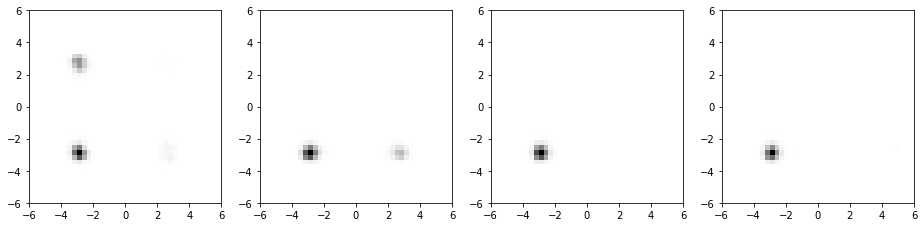

In [9]:
plt.figure(figsize=(20, 8))
for i in range(chains):
    plt.subplot(1, chains + 1, int(i + 1), aspect="equal")
    plt.hist2d(
        samples_RWMH_parallel[i][0, :],
        samples_RWMH_parallel[i][1, :],
        cmap=plt.get_cmap("Greys"),
        bins=40,
        range=[[-6, 6], [-6, 6]],
    )
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])

(-6.0, 6.0)

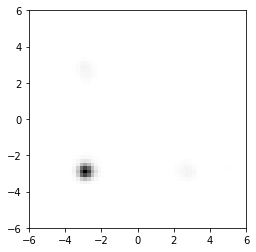

In [10]:
m1 = []
m2 = []
for i in range(chains):
    m1.append(samples_RWMH_parallel[i][0, :])
    m2.append(samples_RWMH_parallel[i][1, :])

m1 = numpy.hstack(m1)
m2 = numpy.hstack(m2)

plt.subplot(1, 1, 1, aspect="equal")

plt.hist2d(
    m1,
    m2,
    cmap=plt.get_cmap("Greys"),
    bins=60,
    range=[[-6, 6], [-6, 6]],
)
plt.xlim([-6, 6])
plt.ylim([-6, 6])

In [11]:
for i, (smpl, fn, pos, inmo) in enumerate(
    zip(samplers, filenames, posteriors, initial_model)
):
    smpl.sample(
        f"{fn.replace('.h5','-seq.h5')}",
        pos,
        proposals=n_samples,
        initial_model=inmo,
        overwrite_existing_file=True,
    ).print_results()

In [12]:
resample = True

# Set up parallel Markov chains by generating 3 copies of everything -------------------

# 3 samplers
samplers = [hmclab.Samplers.HMC() for i in range(chains)]

# 3 posteriors (that are not the same!)
temperatures = base_temperature * 3 ** numpy.arange(chains)
print(f"Temperatures: {temperatures}")

posteriors = [StyblinskiTang(temperature=temp) for temp in temperatures]

# 3 separate sample files
filenames = [
    f"bin_samples/tutorial_4_varying_temp_coupled_chains_{i}.h5" for i in range(chains)
]

# Execute parallel sampling
parallel_sampler = hmclab.Samplers.ParallelSampleSMP()

numpy.random.seed(6254)

initial_model = [
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
    numpy.random.rand(2, 1) * 10 - 5,
]

parallel_sampler.sample(
    samplers,
    filenames,
    posteriors,
    proposals=n_samples,
    overwrite_existing_files=True,
    exchange=True,
    exchange_interval=10,
    initial_model=initial_model,
)

Temperatures: [ 3  9 27 81]
Starting 4 markov chains...
    





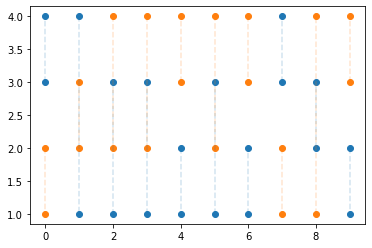

In [13]:
n = 10

n_swaps = int(chains / 2)

cmap = plt.get_cmap("tab10")

for sw in range(n_swaps):
    plt.scatter(
        range(n), 1 + parallel_sampler.exchange_schedule[0:n, sw * 2], color=cmap(sw)
    )
    plt.scatter(
        range(n),
        1 + parallel_sampler.exchange_schedule[0:n, sw * 2 + 1],
        color=cmap(sw),
    )

    for i in range(n):
        plt.plot(
            [i, i],
            1 + parallel_sampler.exchange_schedule[i, sw * 2 : sw * 2 + 2],
            "--",
            color=cmap(sw),
            alpha=0.2,
        )

In [14]:
# Sample the posteriors with a single chain separately

filenames_uncoupled = [
    f"bin_samples/tutorial_4_varying_temp_uncoupled_chains_samples_{i}.h5"
    for i in range(chains)
]

for i, posterior in enumerate(posteriors):
    sampler = hmclab.Samplers.HMC()

    if resample:
        sampler.sample(
            filenames_uncoupled[i],
            posterior,
            proposals=n_samples,
            autotuning=False,
            overwrite_existing_file=True,
            initial_model=initial_model[i],
        )

In [15]:
samples_objs_parallel = [hmclab.Samples(filename) for filename in filenames]
samples_RWMH_parallel = [so.numpy for so in samples_objs_parallel]
for so in samples_objs_parallel:
    so.close()
    del so

samples_objs = [hmclab.Samples(filename) for filename in filenames_uncoupled]
samples_RWMH = [so.numpy for so in samples_objs]
for so in samples_objs:
    so.close()
    del so

Text(-10, 0, 'Coupled chains')

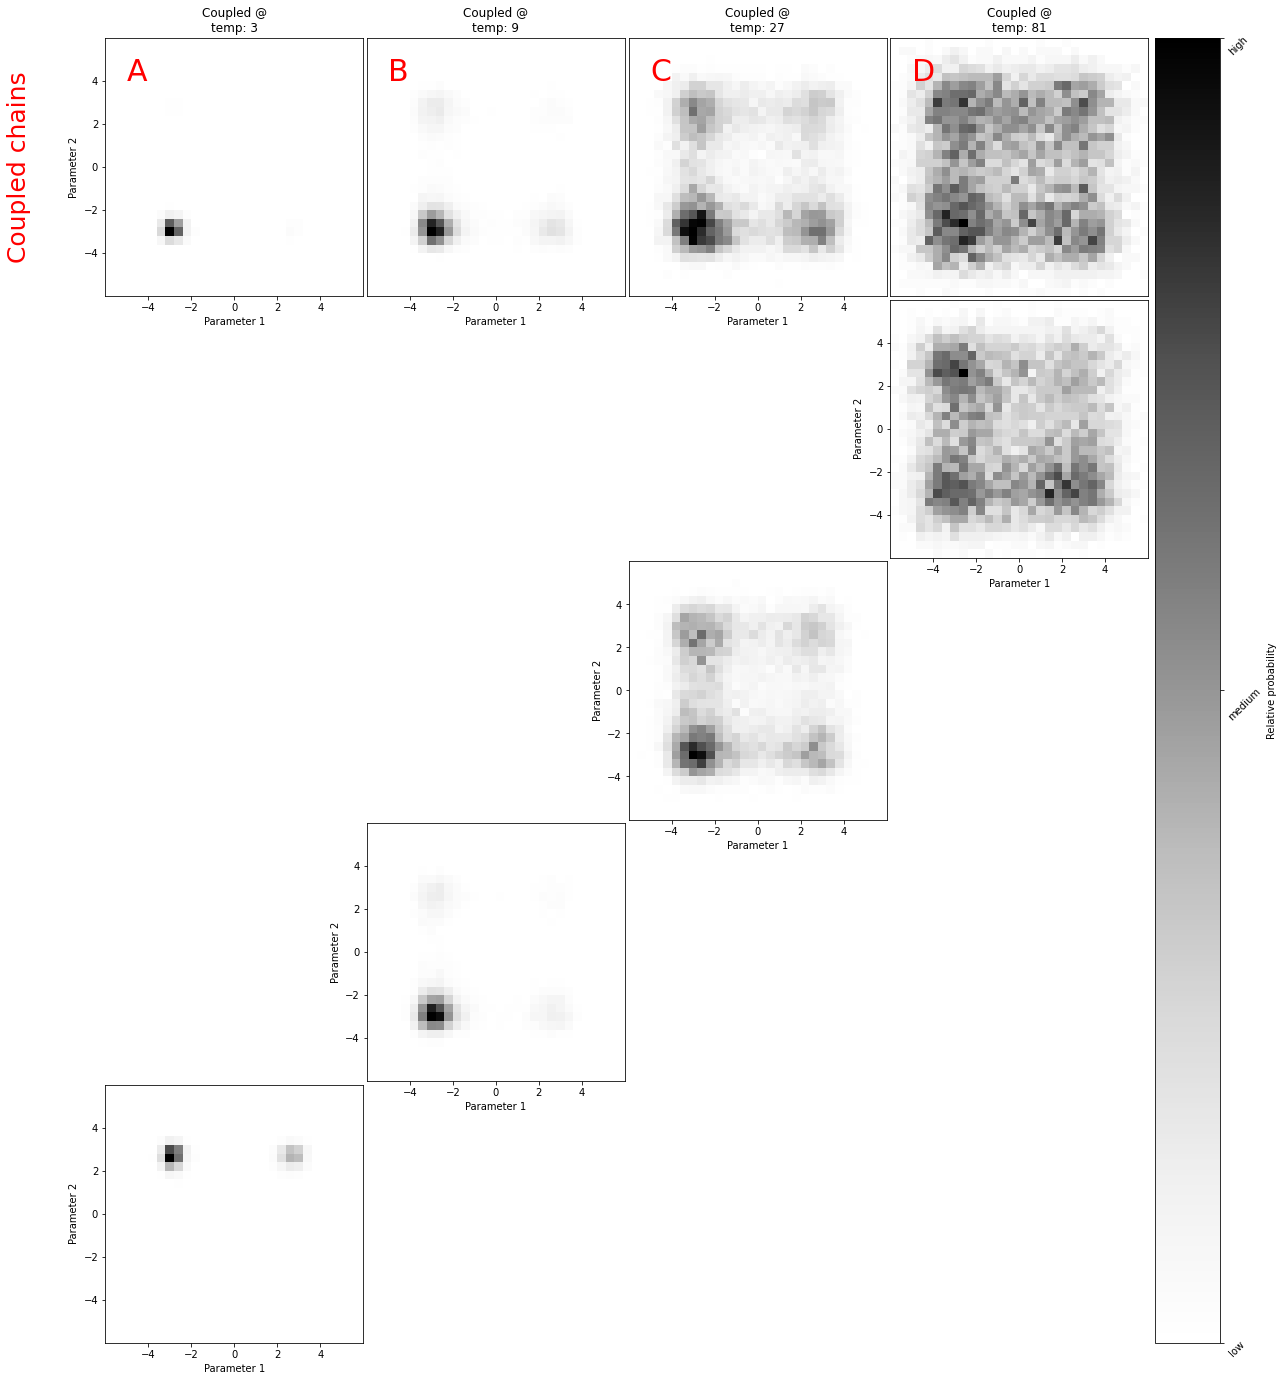

In [16]:
fig = plt.figure(figsize=(48, 24))

labels = ["A", "B", "C", "D", "E", "F"]

grid = AxesGrid(
    fig,
    111,
    nrows_ncols=(chains + 1, chains),
    label_mode="0",
    axes_pad=0.05,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.1,
)

for i in range(chains):
    axis = grid[i]
    axis.set_title(f"Coupled @\ntemp: {posteriors[i].temperature}")

    axis.hist2d(
        samples_RWMH_parallel[i][0, :],
        samples_RWMH_parallel[i][1, :],
        cmap=plt.get_cmap("Greys"),
        bins=30,
        range=[[-6, 6], [-6, 6]],
    )
    axis.set_xlim([-6, 6])
    axis.set_ylim([-6, 6])

    axis.set_xlabel("Parameter 1")
    axis.set_ylabel("Parameter 2")

    axis.xaxis.get_major_ticks()[-1].set_visible(False)
    axis.xaxis.get_major_ticks()[0].set_visible(False)
    axis.yaxis.get_major_ticks()[-1].set_visible(False)
    axis.yaxis.get_major_ticks()[0].set_visible(False)
    axis.text(-5, 4, labels[i], size=30, color="red")

grid[chains - 1].xaxis.set_visible(False)

for ichain in range(chains - 1):
    grid[ichain + 1].yaxis.set_visible(False)

all_axes = range(chains * 4)

all_except_first = set([i for i in range(chains * (chains + 1))]) - set(
    [i for i in range(chains)]
)
anti_diagona_plots = [
    ichain * chains + chains * 2 - 1 - 1 * ichain for ichain in range(chains)
]


for axes in list(all_except_first - set(anti_diagona_plots)):
    grid[axes].set_axis_off()

for i in range(chains):

    axis = grid[anti_diagona_plots[chains - i - 1]]
    h2d = axis.hist2d(
        samples_RWMH[i][0, :],
        samples_RWMH[i][1, :],
        cmap=plt.get_cmap("Greys"),
        bins=30,
        range=[[-6, 6], [-6, 6]],
    )
    axis.set_xlim([-6, 6])
    axis.set_ylim([-6, 6])
    axis.set_xlabel("Parameter 1")
    axis.set_ylabel("Parameter 2")

    cbar = axis.cax.colorbar(h2d[3])
    # cbar = grid.cbar_axes[0].colorbar(h2d[3])

    axis.cax.set_yticks([0, h2d[0].max() / 2, h2d[0].max()])
    axis.cax.set_yticklabels(["low", "medium", "high"], rotation=45)

    axis.cax.set_ylabel("Relative probability")

    axis.yaxis.get_major_ticks()[-1].set_visible(False)
    axis.yaxis.get_major_ticks()[0].set_visible(False)
    axis.xaxis.get_major_ticks()[-1].set_visible(False)
    axis.xaxis.get_major_ticks()[0].set_visible(False)

#     axis.text(-5, 4, labels[i + chains], size=50, color="red")

grid[0].text(
    -10,
    0,
    "Coupled chains",
    size=25,
    color="red",
    ha="center",
    va="center",
    rotation="vertical",
)